In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import os
from sklearn.metrics import r2_score
import pickle

# Subnetwork

In [2]:
predicted_nodes = [
    "RB",
    "ERK12",
    "JNK",
    "cleavedCas",
    "p38",
    "MKK36",
    "MAPKAPK2",
    "p90RSK",
    "p53",
    "CREB",
    "H3",
    "MEK12",]

treatments = ['iPKC', 'iPI3K', 'iMEK', 'EGF', 'iEGFR', 'imTOR']

In [3]:
client = mlflow.tracking.MlflowClient(tracking_uri="http://localhost:5000")
exp_id = client.get_experiment_by_name("OneCellLineOneTreatment").experiment_id
runs = client.search_runs(experiment_ids=exp_id)
runs_df = pd.DataFrame([{ **dict(run.info), **run.data.params, **run.data.metrics} for run in runs])
runs_df["treatment"] = [x[79:-10] for x in runs_df["data_file"]]

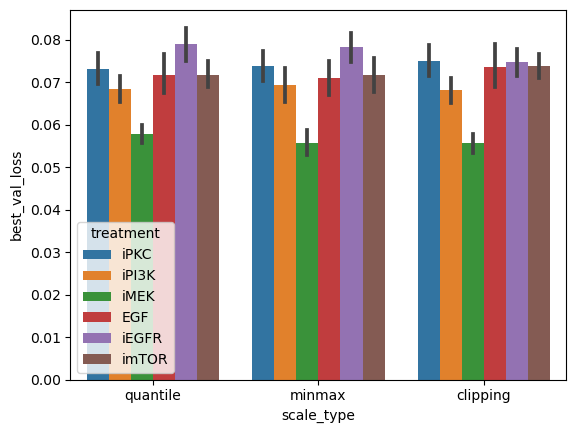

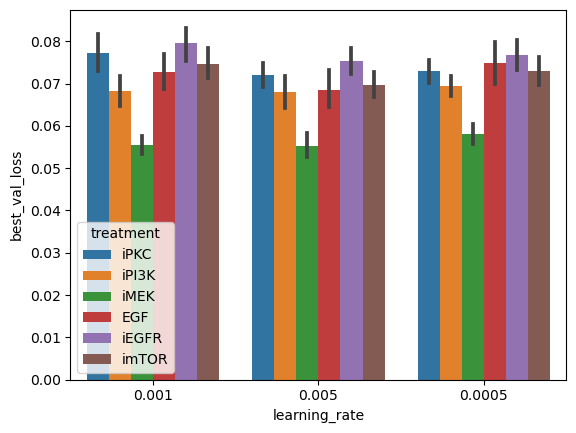

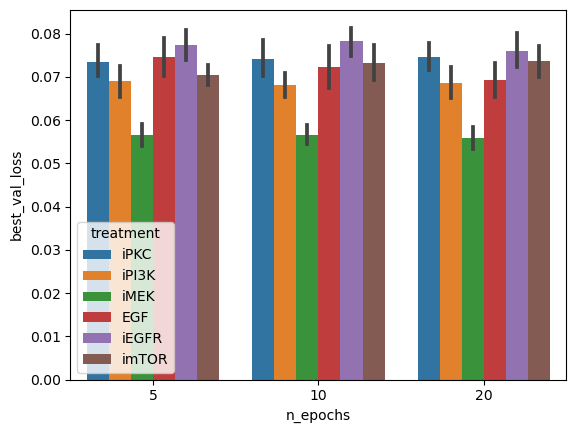

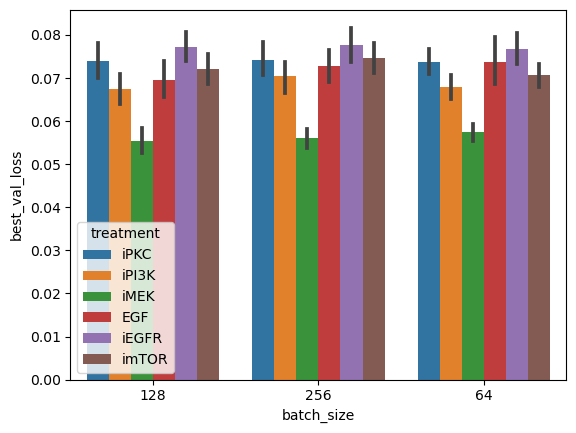

In [4]:
sns.barplot(data=runs_df, x="scale_type", y="best_val_loss", hue="treatment")
plt.show()
sns.barplot(data=runs_df, x="learning_rate", y="best_val_loss", hue="treatment")
plt.show()
sns.barplot(data=runs_df, x="n_epochs", y="best_val_loss", hue="treatment")
plt.show()
sns.barplot(data=runs_df, x="batch_size", y="best_val_loss", hue="treatment")
plt.show()

In [5]:
best_runs = []
for tr in treatments:
    sel_run = runs_df.loc[runs_df["treatment"]==tr, :].sort_values("best_val_loss", ascending=True).iloc[0,:]
    best_runs.append(sel_run)
    
best_runs = pd.concat(best_runs, axis=1).T.reset_index(drop=True)
best_runs[["treatment", "param_setting"]]

treatment param_setting
0      iPKC           280
1     iPI3K           435
2      iMEK           272
3       EGF           198
4     iEGFR             7
5     imTOR           293

In [6]:
for n in predicted_nodes:
    print(n, best_runs[["treatment", f"val_r2_{n}"]])



RB   treatment val_r2_RB
0      iPKC  0.113496
1     iPI3K  0.083603
2      iMEK  0.071325
3       EGF  -0.06587
4     iEGFR  0.106125
5     imTOR  0.027841
ERK12   treatment val_r2_ERK12
0      iPKC    -8.010864
1     iPI3K    -6.719063
2      iMEK     -1.36948
3       EGF    -7.896606
4     iEGFR    -8.816015
5     imTOR    -6.186299
JNK   treatment val_r2_JNK
0      iPKC  -2.067079
1     iPI3K   -0.41905
2      iMEK  -0.475046
3       EGF  -1.346905
4     iEGFR   -4.49999
5     imTOR  -0.007259
cleavedCas   treatment val_r2_cleavedCas
0      iPKC         -0.212127
1     iPI3K         -0.275917
2      iMEK          -0.09211
3       EGF          -1.68848
4     iEGFR          -2.25369
5     imTOR         -0.317967
p38   treatment val_r2_p38
0      iPKC  -0.061779
1     iPI3K   -0.17674
2      iMEK  -0.461195
3       EGF    0.12481
4     iEGFR  -3.232207
5     imTOR  -0.637876
MKK36   treatment val_r2_MKK36
0      iPKC    -0.497377
1     iPI3K    -0.821415
2      iMEK    -1.107816
3    

In [7]:
all_m_pred = []
all_m_test = []
for tr in treatments:
    model_dir = f"/Users/adr/Box/CARs/BFN/Model/OneCellLineOneTreatment/{tr}/"
    m_test = pd.read_csv(os.path.join(model_dir, "valid_data.csv"), index_col = [0, 1]).reset_index(drop=True)
    m_pred = pd.read_csv(os.path.join(model_dir, "valid_output_states.csv"), index_col=0)
    
    all_m_pred.append(m_pred)
    all_m_test.append(m_test)



In [8]:
m_pred = pd.concat(all_m_pred, keys=treatments, names=["treatment", ""]).reset_index("treatment", drop=False).reset_index(drop=True)
m_test = pd.concat(all_m_test).reset_index(drop=True)
m_test



treatment cell_line  time  cellID  fileID  b-catenin  cleavedCas  \
0          iPKC      BT20   9.0  4154.0   190.0   0.224784    0.039640   
1          iPKC      BT20   9.0    74.0   190.0   0.483047    0.184481   
2          iPKC      BT20   9.0  3141.0   190.0   1.621428    0.288850   
3          iPKC      BT20   9.0  5349.0   190.0   0.771049    0.197859   
4          iPKC      BT20   9.0  3654.0   190.0   1.235426    0.140478   
...         ...       ...   ...     ...     ...        ...         ...   
16245     imTOR      BT20   9.0  1484.0   184.0   0.741565    0.146664   
16246     imTOR      BT20   9.0  9779.0   184.0   0.716464    0.042791   
16247     imTOR      BT20   9.0  8253.0   184.0   0.534428    0.175140   
16248     imTOR      BT20   9.0  8466.0   184.0   0.523540    0.000000   
16249     imTOR      BT20   9.0  6539.0   184.0   1.152272    0.244114   

       CyclinB     GAPDH       IdU  ...       S6    p70S6K    SMAD23  \
0      2.24295  2.083673   6.11556  ...  4.21116  1.998364  0.113202   
1      2.33928  2.910371   4.81931  ...  7.22025  2.436430  0.647325   
2      3.94386  3.245311   7.79478  ...  6.63908  0.533035  0.632122   
3      2.03202  2.214317   5.48218  ...  3.38360  1.122666  0.646455   
4      3.30754  2.390110   4.91810  ...  5.23083  1.726450  0.602215   
...        ...       ...       ...  ...      ...       ...       ...   
16245  3.09091  1.691854  11.64001  ...  3.44882  1.098691  0.273711   
16246  1.33673  2.010965   4.25020  ...  3.34950  1.085819  0.229882   
16247  1.20489  1.869498   5.80414  ...  5.33145  1.804634  0.129858   
16248  1.95130  3.435692   5.23046  ...  5.14076  2.667919  0.347309   
16249  2.70292  2.610258   6.54029  ...  6.46621  2.979050  0.671855   

                SRC     STAT1     STAT3     STAT5  time_course  inhibitor  \
0      5.141181e-01  2.974261  3.312604  3.300072            A        PKC   
1      1.475534e-01  3.238080  3.747701  3.146393            A        PKC   
2      4.556240e-01  3.341057  1.710681  2.677713            A        PKC   
3      5.851729e-01  3.237510  2.221436  3.535651            A        PKC   
4      6.101145e-01  3.484376  3.312010  2.804057            A        PKC   
...             ...       ...       ...       ...          ...        ...   
16245  1.000000e-09  2.435097  2.517381  1.427256          NaN       mTOR   
16246  5.397105e-01  2.646212  4.027884  3.017306          NaN       mTOR   
16247  5.450861e-01  2.781195  2.844637  3.189000          NaN       mTOR   
16248  4.895037e-01  3.231914  5.289472  3.092161          NaN       mTOR   
16249  4.934930e-01  3.669929  3.205158  2.601341          NaN       mTOR   

       EGFR  
0       1.0  
1       1.0  
2       1.0  
3       1.0  
4       1.0  
...     ...  
16245   1.0  
16246   1.0  
16247   1.0  
16248   1.0  
16249   1.0  

[16250 rows x 45 columns]

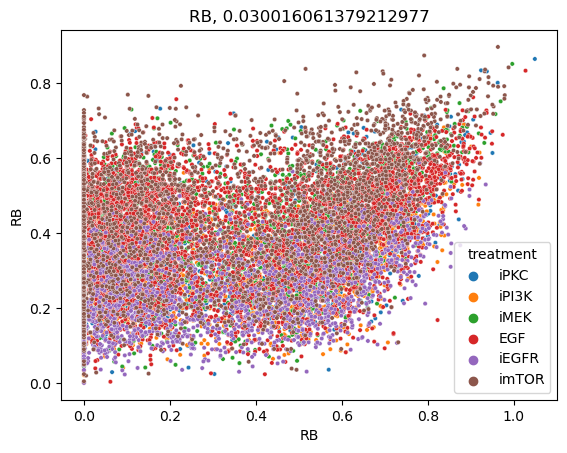

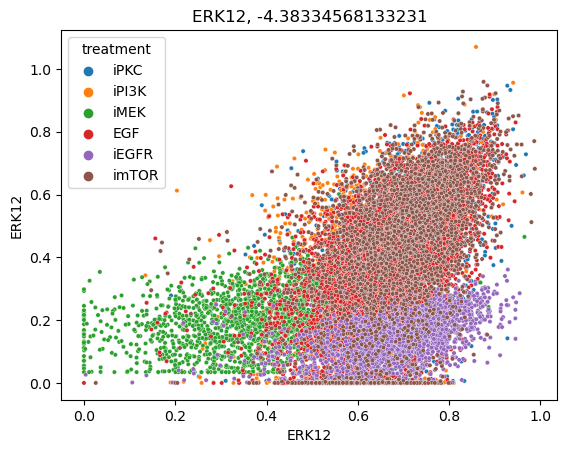

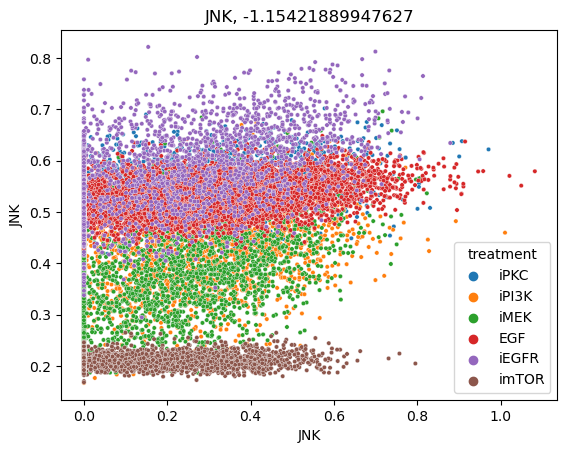

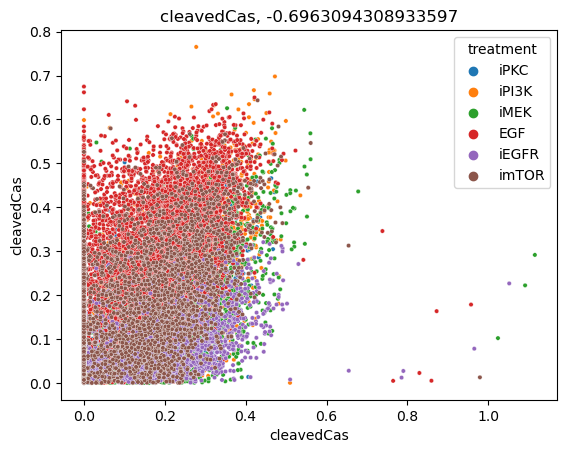

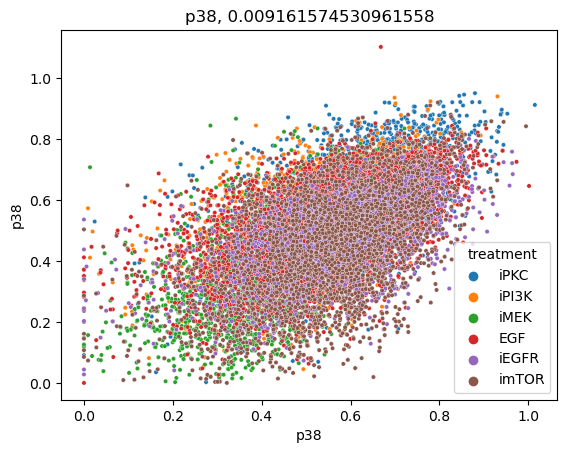

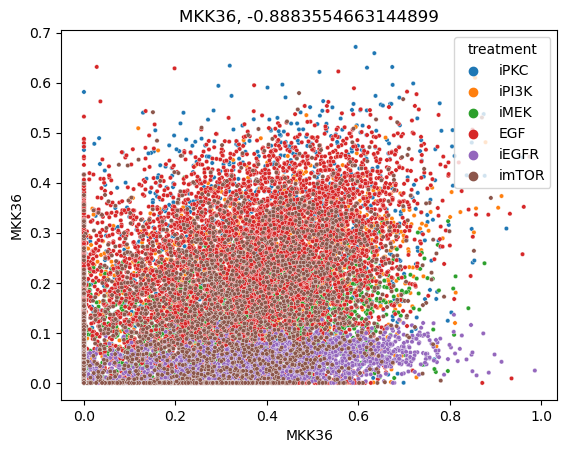

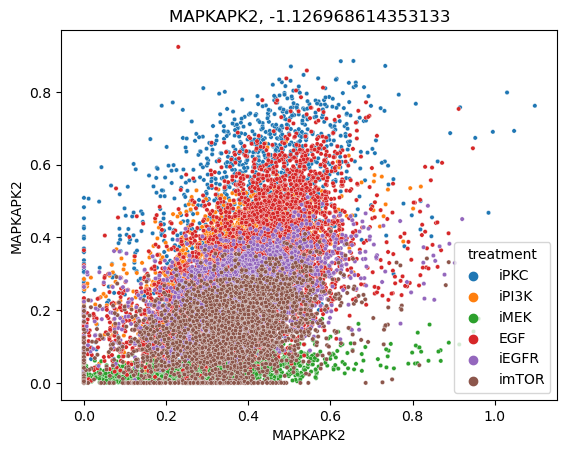

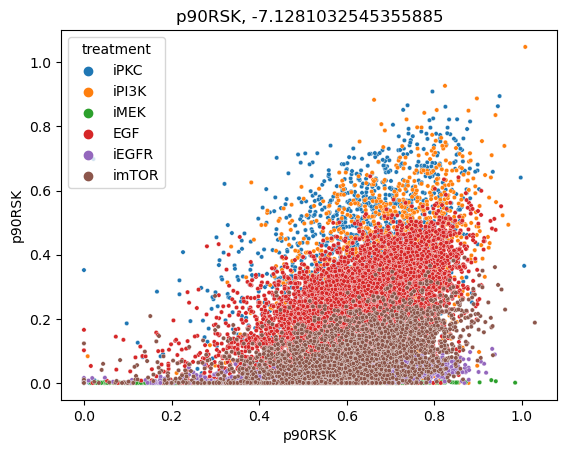

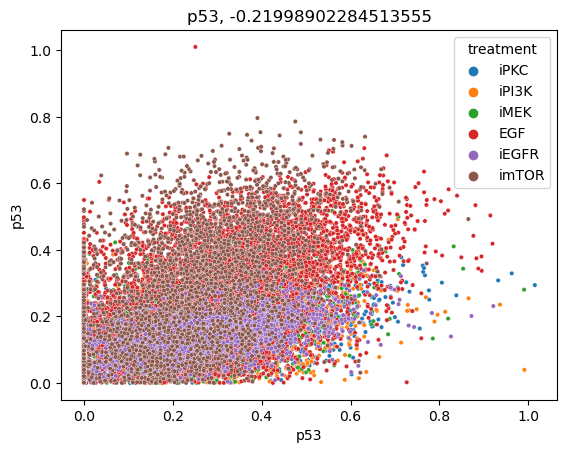

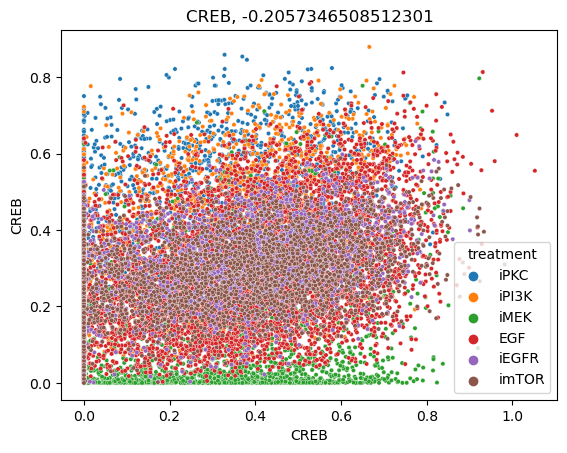

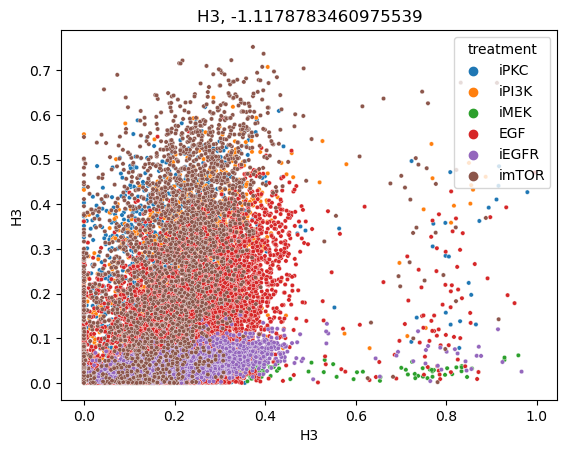

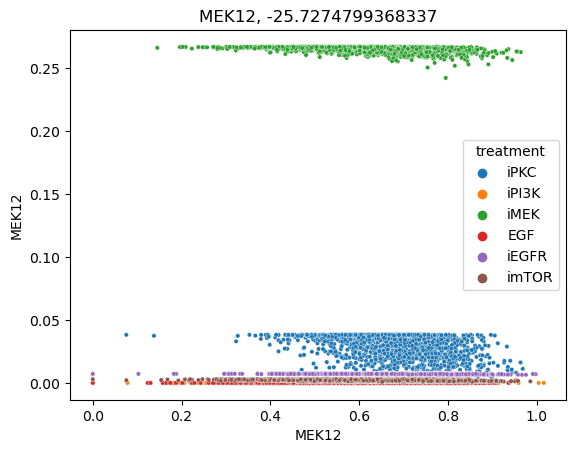

In [9]:
m_r2 = []
for n in predicted_nodes:
    sns.scatterplot(x=m_test[n], y=m_pred[n], hue=m_test["treatment"], s =10)
    r2 = r2_score(m_test[n], m_pred[n])
    plt.title(f"{n}, {r2}")
    plt.show()
    m_r2.append(r2)

In [10]:
baseline_dir = "/Users/adr/Box/CARs/BFN/Model/Baseline/RF_OneCellLineOneTreatment_SN_inputs/"
bl_test = np.load(os.path.join(baseline_dir, "RF_OneCellLine_test.npy"), allow_pickle=True)
bl_test = pd.DataFrame(bl_test).iloc[:, 1:40]
bl_test.columns = m_test.iloc[:, 0:39].columns

In [11]:
bl_test

treatment cell_line time  cellID fileID b-catenin cleavedCas  CyclinB  \
0          iPKC      BT20  9.0  3778.0  190.0  0.224784   1.860725  1.78549   
1         iPI3K      BT20  9.0  7339.0  178.0  2.658974   2.113634  2.86031   
2         iEGFR      BT20  9.0  2403.0  186.0  0.224784   3.198822  3.78062   
3          iPKC      BT20  9.0  3177.0  190.0  0.706925   1.708631  1.20489   
4         imTOR      BT20  9.0  5127.0  184.0  0.853234   2.586705  2.69296   
...         ...       ...  ...     ...    ...       ...        ...      ...   
16244       EGF      BT20  9.0  6200.0  176.0  0.224784   0.898342  1.20489   
16245       EGF      BT20  9.0  7734.0  176.0  0.224784   0.898342  2.15712   
16246     iPI3K      BT20  9.0  5560.0  178.0  1.277367   0.898342  1.20489   
16247      iPKC      BT20  9.0  1225.0  190.0  0.636751   2.212177  1.34134   
16248       EGF      BT20  9.0  6430.0  217.0  1.932778   3.491587  1.58942   

          GAPDH       IdU  ...       p38       p53   p90RSK     PDPK1  \
0      2.289077    4.2502  ...  3.281282  1.508538  3.97774  1.388843   
1      3.986792   5.31821  ...  3.555418  2.837195   6.0857  2.488651   
2      3.001924   10.5024  ...  3.723785  2.487505  4.27507  2.158701   
3      1.293746   5.35679  ...  3.249814  1.583133  4.30821  1.421305   
4       1.50766  10.88998  ...  2.785449  0.798554   3.8279  2.016546   
...         ...       ...  ...       ...       ...      ...       ...   
16244  2.501116   5.23238  ...   2.23581  1.529046  3.56578  0.516309   
16245  2.587531   4.72384  ...  3.512061  2.972791  4.34897  0.903189   
16246  2.108733    5.3029  ...  2.936137  1.965922  4.43028  0.951464   
16247  2.929665   6.27622  ...  4.090756  2.304164  5.05959  2.417411   
16248  3.429268   6.34117  ...  3.793436  3.487235  5.90419  2.671514   

          PLCg2       RB       S6    p70S6K    SMAD23       SRC  
0      2.842665  2.83125  3.29845  2.621112  1.478653  1.813159  
1      4.995442  7.74658  8.66102  2.912239  3.424576  3.013575  
2      2.828363  7.18341  7.39216  1.119976  2.176797  2.542155  
3      3.703491  4.18855  2.92998  1.952795   1.94185  2.163074  
4           NaN  5.87262  3.27795  2.133778  1.951001  1.788658  
...         ...      ...      ...       ...       ...       ...  
16244   1.97265  2.32867  4.35869  2.524787  0.551474  2.204185  
16245  3.247073  2.20794   5.7054  1.867119  0.551474  2.146306  
16246  3.258584   6.4754  6.44771  3.160924  0.863531  2.746595  
16247  3.836592  2.76271  4.78976  2.284201  2.009923  2.256177  
16248  4.965475  3.77594  7.66551  3.117051  2.321267  4.122504  

[16249 rows x 39 columns]

In [12]:
all_pred = []
names = []
for f in os.listdir(baseline_dir):
    if not f.startswith("RF_"):
        pred = np.load(os.path.join(baseline_dir, f))
        if "Cas" in f:
            name = f[:-4]
        elif "MEK" in f or "ERK" in f:
            name = f"{f[2:-4]}12"
        elif "MKK3.MKK6" in f:
            name = "MKK36"
        else:
            name = f[2:-4]
        
        all_pred.append(pred)
        names.append(name)
        
        print(name)

MKK36
p53
H3
MAPKAPK2
p90RSK
CREB
p38
JNK
ERK12
MEK12
RB
cleavedCas


In [13]:
bl_pred = pd.DataFrame(all_pred).T
bl_pred.columns = names
bl_pred

MKK36       p53        H3  MAPKAPK2    p90RSK      CREB       p38  \
0      1.517099  1.630872  2.175780  2.201227  3.717559  1.179752  3.155732   
1      2.743184  3.469282  3.800655  3.240374  5.989600  1.788718  3.595881   
2      1.836954  2.198684  2.583766  2.583540  4.463195  1.408589  3.139326   
3      1.271723  1.841990  1.900920  2.311504  3.761031  1.086088  3.010531   
4      1.948746  2.739387  2.527530  2.605918  4.617514  1.205634  2.953973   
...         ...       ...       ...       ...       ...       ...       ...   
16244  1.509770  1.699752  2.132294  2.306229  3.973649  1.148952  2.686424   
16245  1.462998  1.621131  2.311870  2.208526  4.175019  1.172554  2.491953   
16246  1.685342  2.262774  2.483739  2.454518  4.354226  1.447795  3.072312   
16247  1.845356  3.100200  2.872335  3.116526  5.219196  1.587943  3.873383   
16248  2.264962  3.410024  3.474144  3.570691  5.705376  1.998858  4.411320   

            JNK     ERK12     MEK12        RB  cleavedCas  
0      1.191278  3.585454  3.435045  4.201653    1.646034  
1      2.495816  4.935357  4.181603  6.145857    3.352126  
2      1.420927  3.959190  3.643346  4.830215    2.112845  
3      1.176732  3.691096  3.312477  3.804816    1.316314  
4      1.488592  4.536743  3.759387  5.470985    2.062914  
...         ...       ...       ...       ...         ...  
16244  1.213479  3.670102  2.962914  3.243903    1.467767  
16245  1.256064  3.750713  2.915052  3.160172    1.522588  
16246  1.573850  3.954681  3.226546  4.070507    1.925592  
16247  1.613818  4.732239  4.492439  5.960228    2.314478  
16248  1.808962  5.187846  4.386918  5.969573    2.590716  

[16249 rows x 12 columns]

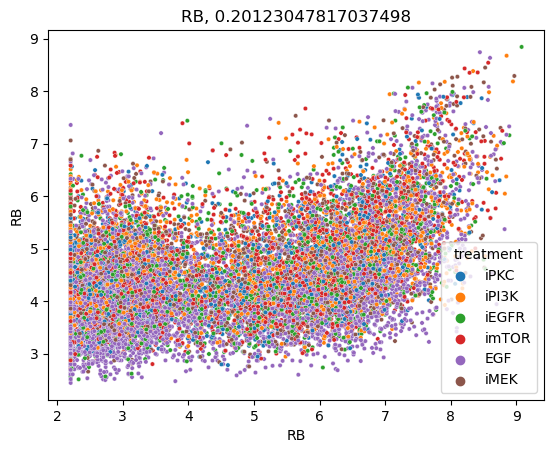

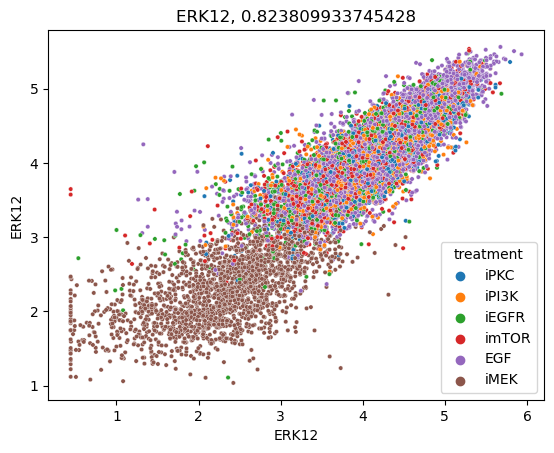

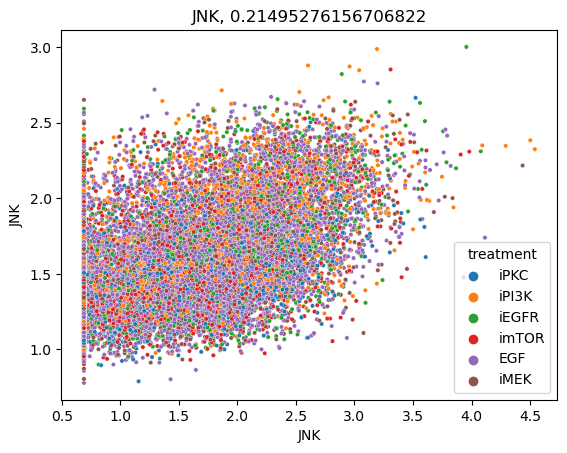

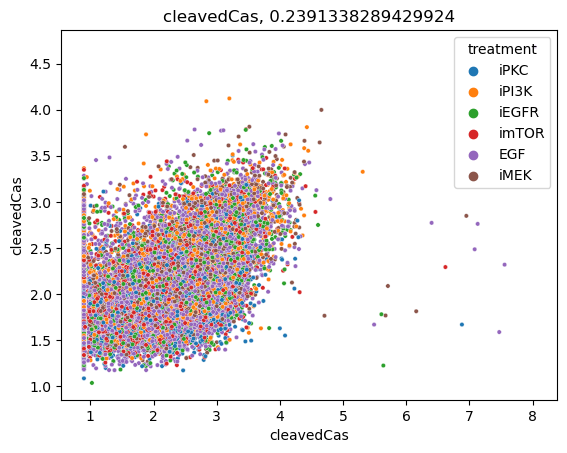

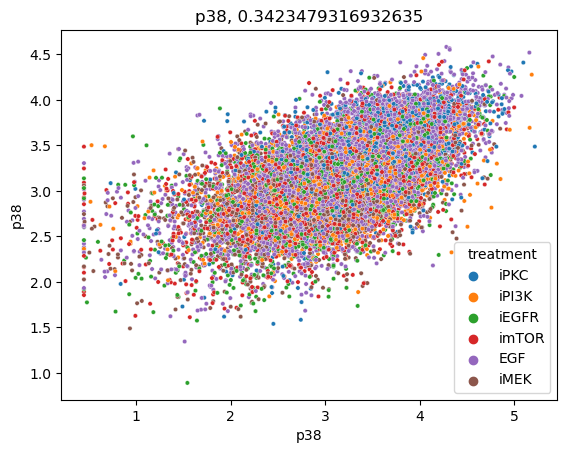

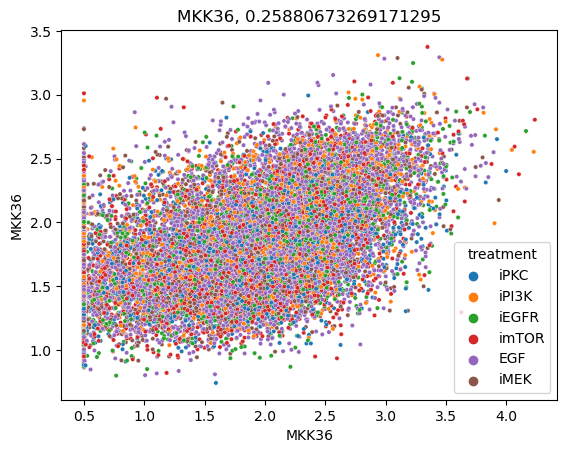

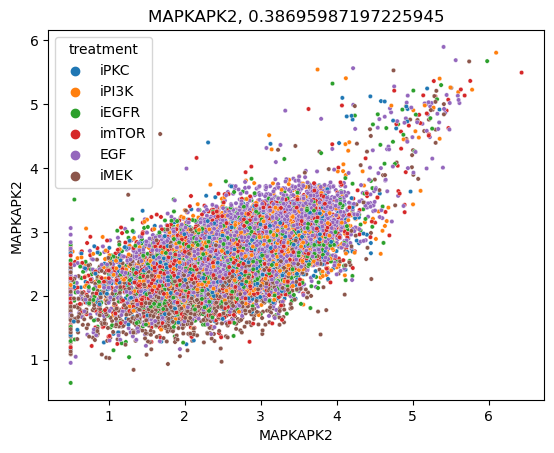

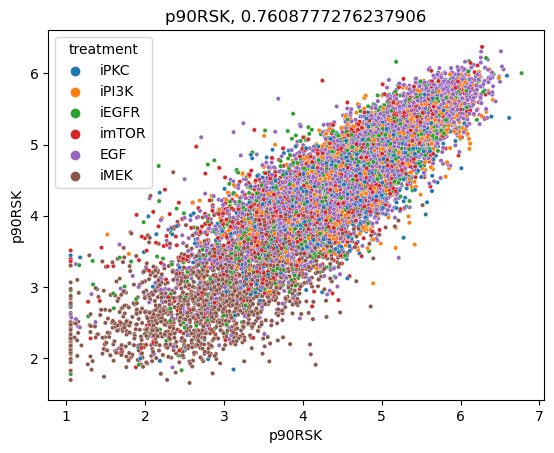

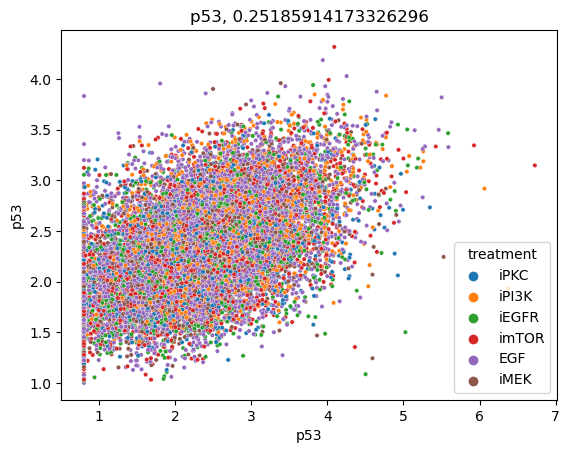

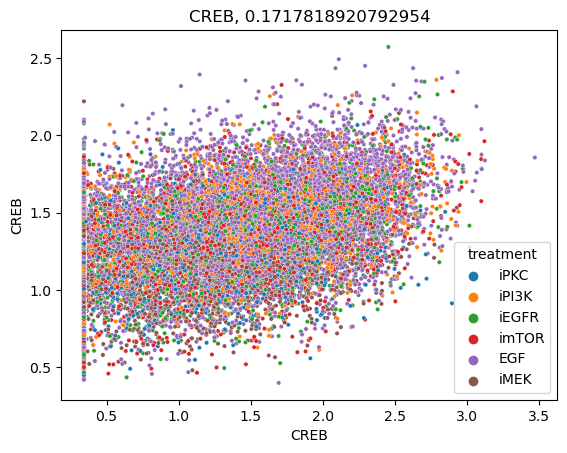

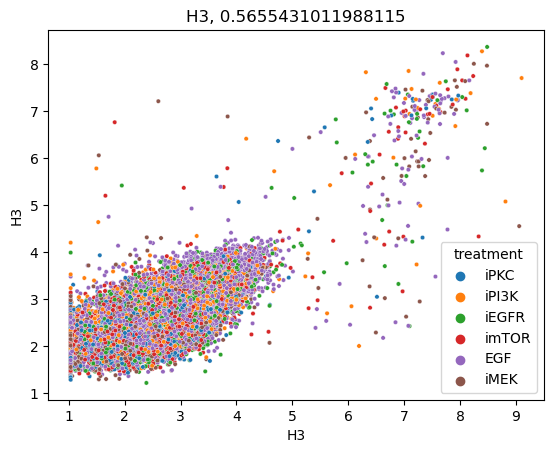

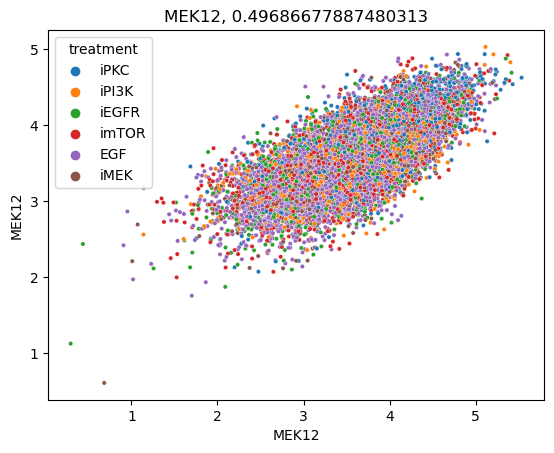

In [14]:
bl_r2 = []
for n in predicted_nodes:
    sns.scatterplot(x=bl_test[n], y=bl_pred[n], hue=bl_test["treatment"], s=10)
    r2 = r2_score(bl_test[n], bl_pred[n])
    plt.title(f"{n}, {r2}")
    plt.show()
    bl_r2.append(r2)

Text(0.5, 1.0, 'One cell line, one treatment on Subnetwork')

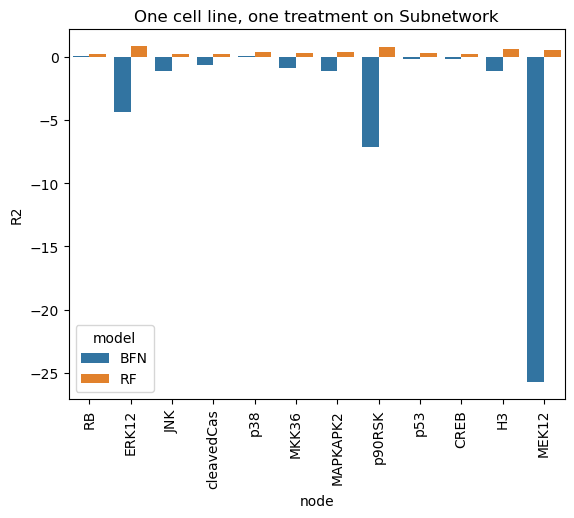

In [15]:
res = pd.DataFrame({"BFN": m_r2, "RF": bl_r2, "node": predicted_nodes})
res = res.melt(id_vars="node", value_vars=["BFN", "RF"], value_name="R2", var_name="model")
sns.barplot(data=res, x="node", y="R2", hue="model")
t = plt.xticks(rotation=90)
plt.title("One cell line, one treatment on Subnetwork")

# MEK FAK ERK

In [16]:
predicted_nodes = ["ERK12"]

In [17]:
client = mlflow.tracking.MlflowClient(tracking_uri="http://localhost:5000")
exp_id = client.get_experiment_by_name("OneCellLineOneTreatment_MEK_FAK_ERK").experiment_id
runs = client.search_runs(experiment_ids=exp_id)
runs_df = pd.DataFrame([{ **dict(run.info), **run.data.params, **run.data.metrics} for run in runs])
runs_df["treatment"] = [x[79:-10] for x in runs_df["data_file"]]

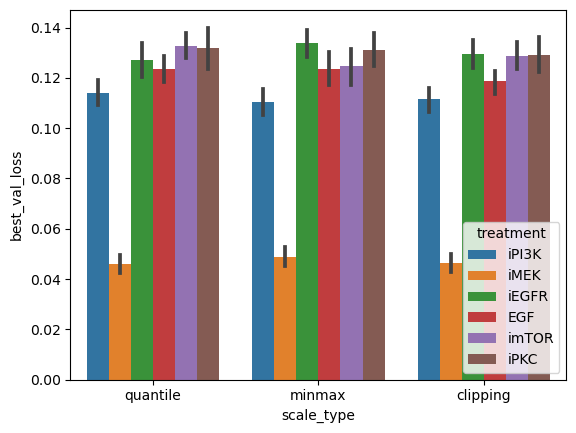

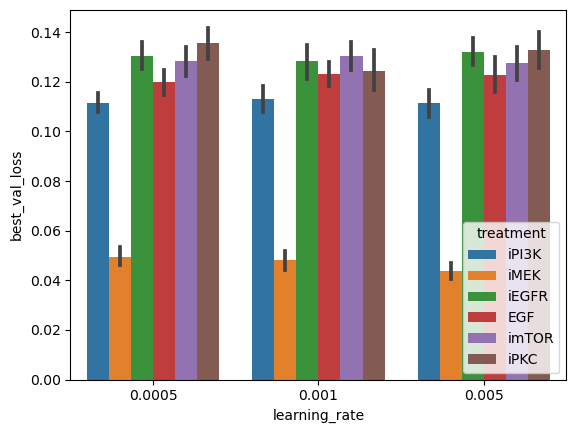

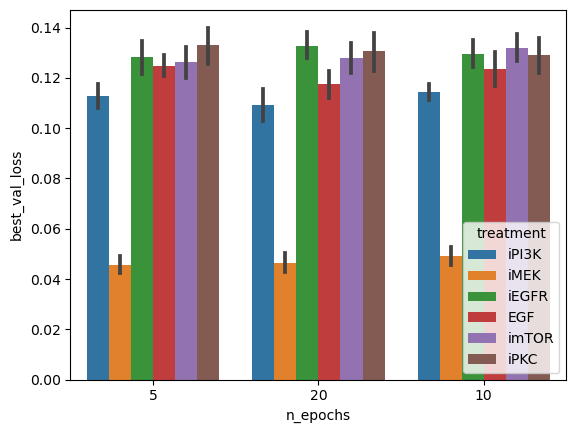

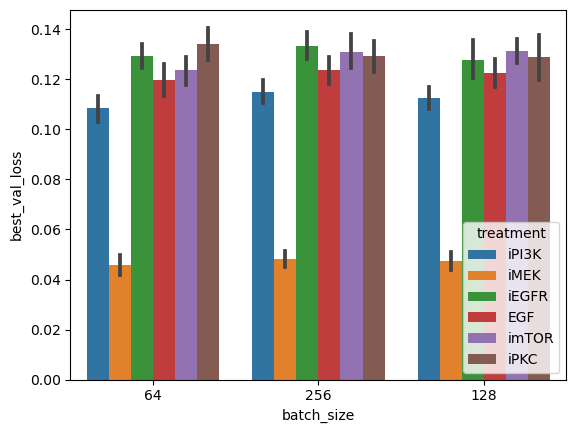

In [18]:

sns.barplot(data=runs_df, x="scale_type", y="best_val_loss", hue="treatment")
plt.show()
sns.barplot(data=runs_df, x="learning_rate", y="best_val_loss", hue="treatment")
plt.show()
sns.barplot(data=runs_df, x="n_epochs", y="best_val_loss", hue="treatment")
plt.show()
sns.barplot(data=runs_df, x="batch_size", y="best_val_loss", hue="treatment")
plt.show()

In [19]:
best_runs = []
for tr in treatments:
    sel_run = runs_df.loc[runs_df["treatment"]==tr, :].sort_values("best_val_loss", ascending=True).iloc[0,:]
    best_runs.append(sel_run)
    
best_runs = pd.concat(best_runs, axis=1).T.reset_index(drop=True)
best_runs[["treatment", "param_setting"]]

treatment param_setting
0      iPKC           262
1     iPI3K           105
2      iMEK           410
3       EGF           138
4     iEGFR           223
5     imTOR            59

In [20]:
for n in predicted_nodes:
    print(n, best_runs[["treatment", f"val_r2_{n}"]])



ERK12   treatment val_r2_ERK12
0      iPKC   -20.518398
1     iPI3K    -13.21324
2      iMEK    -1.864957
3       EGF   -21.128219
4     iEGFR   -12.081301
5     imTOR   -18.302556


In [21]:
all_m_pred = []
all_m_test = []
for tr in treatments:
    model_dir = f"/Users/adr/Box/CARs/BFN/Model/OneCellLineOneTreatment/{tr}/"
    m_test = pd.read_csv(os.path.join(model_dir, "valid_data.csv"), index_col = [0, 1]).reset_index(drop=True)
    m_pred = pd.read_csv(os.path.join(model_dir, "valid_output_states.csv"), index_col=0)
    
    all_m_pred.append(m_pred)
    all_m_test.append(m_test)

m_pred = pd.concat(all_m_pred, keys=treatments, names=["treatment", ""]).reset_index("treatment", drop=False).reset_index(drop=True)
m_test = pd.concat(all_m_test).reset_index(drop=True)
m_test

treatment cell_line  time  cellID  fileID  b-catenin  cleavedCas  \
0          iPKC      BT20   9.0  4154.0   190.0   0.224784    0.039640   
1          iPKC      BT20   9.0    74.0   190.0   0.483047    0.184481   
2          iPKC      BT20   9.0  3141.0   190.0   1.621428    0.288850   
3          iPKC      BT20   9.0  5349.0   190.0   0.771049    0.197859   
4          iPKC      BT20   9.0  3654.0   190.0   1.235426    0.140478   
...         ...       ...   ...     ...     ...        ...         ...   
16245     imTOR      BT20   9.0  1484.0   184.0   0.741565    0.146664   
16246     imTOR      BT20   9.0  9779.0   184.0   0.716464    0.042791   
16247     imTOR      BT20   9.0  8253.0   184.0   0.534428    0.175140   
16248     imTOR      BT20   9.0  8466.0   184.0   0.523540    0.000000   
16249     imTOR      BT20   9.0  6539.0   184.0   1.152272    0.244114   

       CyclinB     GAPDH       IdU  ...       S6    p70S6K    SMAD23  \
0      2.24295  2.083673   6.11556  ...  4.21116  1.998364  0.113202   
1      2.33928  2.910371   4.81931  ...  7.22025  2.436430  0.647325   
2      3.94386  3.245311   7.79478  ...  6.63908  0.533035  0.632122   
3      2.03202  2.214317   5.48218  ...  3.38360  1.122666  0.646455   
4      3.30754  2.390110   4.91810  ...  5.23083  1.726450  0.602215   
...        ...       ...       ...  ...      ...       ...       ...   
16245  3.09091  1.691854  11.64001  ...  3.44882  1.098691  0.273711   
16246  1.33673  2.010965   4.25020  ...  3.34950  1.085819  0.229882   
16247  1.20489  1.869498   5.80414  ...  5.33145  1.804634  0.129858   
16248  1.95130  3.435692   5.23046  ...  5.14076  2.667919  0.347309   
16249  2.70292  2.610258   6.54029  ...  6.46621  2.979050  0.671855   

                SRC     STAT1     STAT3     STAT5  time_course  inhibitor  \
0      5.141181e-01  2.974261  3.312604  3.300072            A        PKC   
1      1.475534e-01  3.238080  3.747701  3.146393            A        PKC   
2      4.556240e-01  3.341057  1.710681  2.677713            A        PKC   
3      5.851729e-01  3.237510  2.221436  3.535651            A        PKC   
4      6.101145e-01  3.484376  3.312010  2.804057            A        PKC   
...             ...       ...       ...       ...          ...        ...   
16245  1.000000e-09  2.435097  2.517381  1.427256          NaN       mTOR   
16246  5.397105e-01  2.646212  4.027884  3.017306          NaN       mTOR   
16247  5.450861e-01  2.781195  2.844637  3.189000          NaN       mTOR   
16248  4.895037e-01  3.231914  5.289472  3.092161          NaN       mTOR   
16249  4.934930e-01  3.669929  3.205158  2.601341          NaN       mTOR   

       EGFR  
0       1.0  
1       1.0  
2       1.0  
3       1.0  
4       1.0  
...     ...  
16245   1.0  
16246   1.0  
16247   1.0  
16248   1.0  
16249   1.0  

[16250 rows x 45 columns]

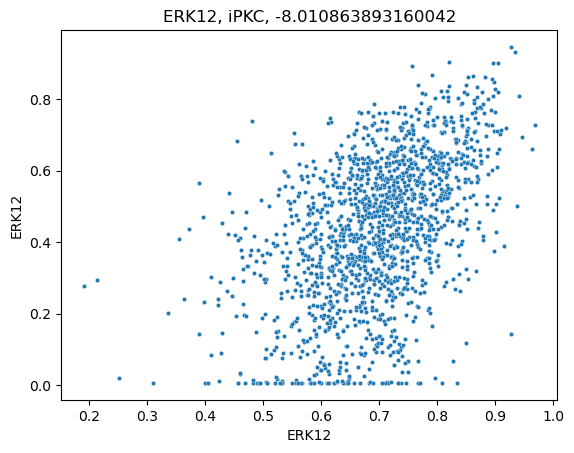

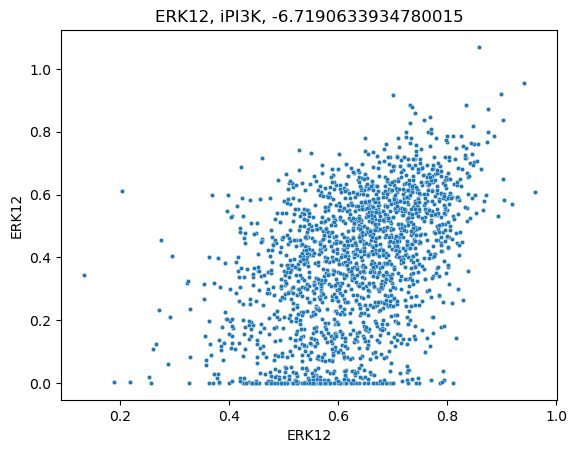

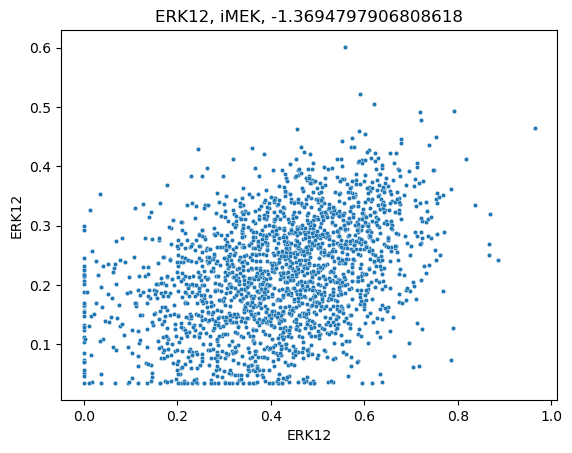

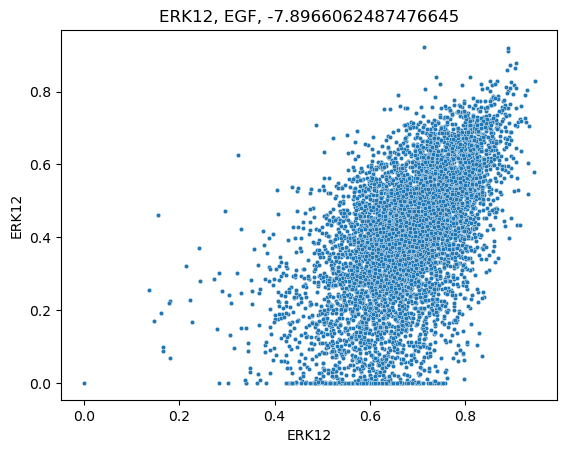

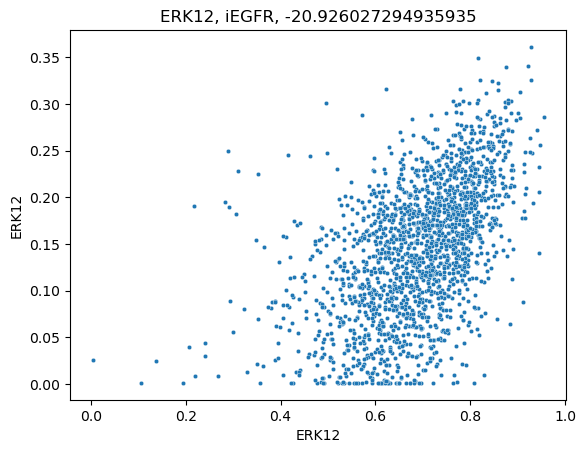

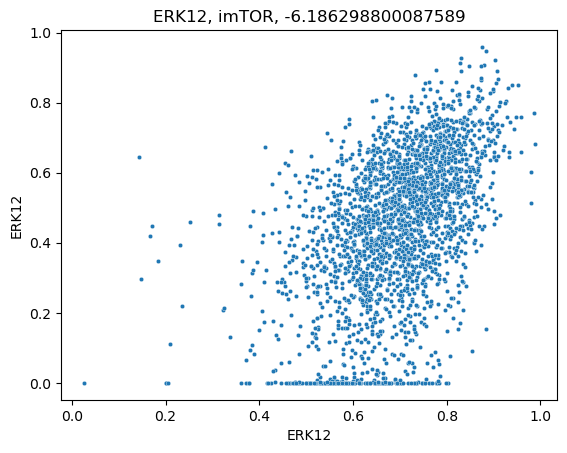

In [22]:
m_r2 = []
for n in predicted_nodes:
    for tr in treatments:
        test = m_test.loc[m_test["treatment"]==tr, n]
        pred = m_pred.loc[m_pred["treatment"]==tr, n]
        sns.scatterplot(x=test, y=pred, s =10)
        r2 = r2_score(test, pred)
        plt.title(f"{n}, {tr}, {r2}")
        plt.show()
        m_r2.append(r2)

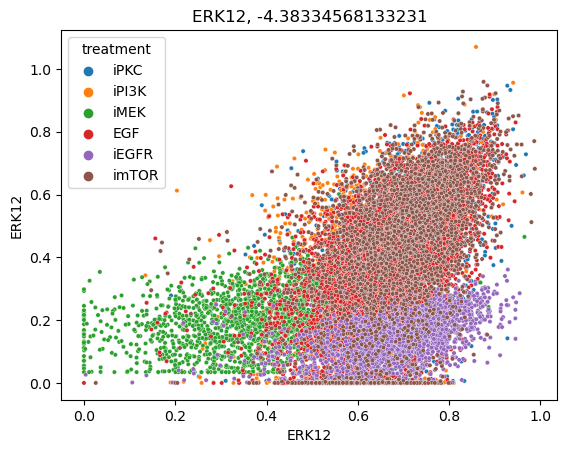

In [23]:
m_r2 = []
for n in predicted_nodes:
    sns.scatterplot(x=m_test[n], y=m_pred[n], hue=m_pred["treatment"], s =10)
    r2 = r2_score(m_test[n], m_pred[n])
    plt.title(f"{n}, {r2}")
    plt.show()
    m_r2.append(r2)

In [24]:
baseline_dir = "/Users/adr/Box/CARs/BFN/Model/Baseline/RF_OneCellLineOneTreatment_MEK_FAK_ERK_MF_inputs/"
bl_test = np.load(os.path.join(baseline_dir, "RF_OneCellLine_test.npy"), allow_pickle=True)
bl_test = pd.DataFrame(bl_test).iloc[:, 1:40]
bl_test.columns = m_test.iloc[:, 0:39].columns

In [25]:
all_pred = []
names = []
for f in os.listdir(baseline_dir):
    if not f.startswith("RF_"):
        pred = np.load(os.path.join(baseline_dir, f))
        if "Cas" in f:
            name = f[:-4]
        elif "MEK" in f or "ERK" in f:
            name = f"{f[2:-4]}12"
        elif "MKK3.MKK6" in f:
            name = "MKK36"
        else:
            name = f[2:-4]
        
        all_pred.append(pred)
        names.append(name)
        
        print(name)

ERK12


In [26]:
bl_pred = pd.DataFrame(all_pred).T
bl_pred.columns = names
bl_pred

ERK12
0      4.836495
1      4.632228
2      4.188948
3      3.736067
4      4.523215
...         ...
16244  4.147072
16245  4.057084
16246  4.028401
16247  3.974361
16248  4.262564

[16249 rows x 1 columns]

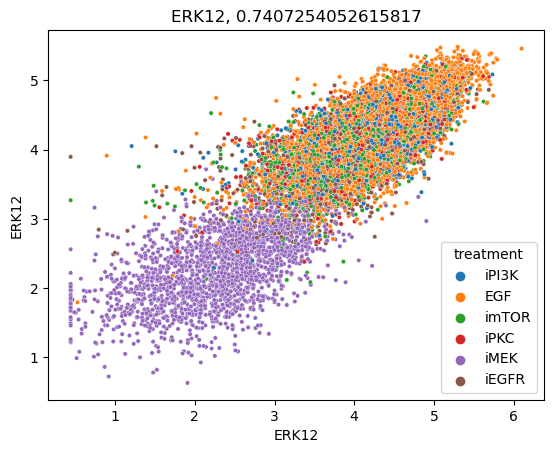

In [27]:
bl_r2 = []
for n in predicted_nodes:
    sns.scatterplot(x=bl_test[n], y=bl_pred[n], hue=bl_test["treatment"], s=10)
    r2 = r2_score(bl_test[n], bl_pred[n])
    plt.title(f"{n}, {r2}")
    plt.show()
    bl_r2.append(r2)

Text(0.5, 1.0, 'One cell line, one treatment on MEK FAK ERK')

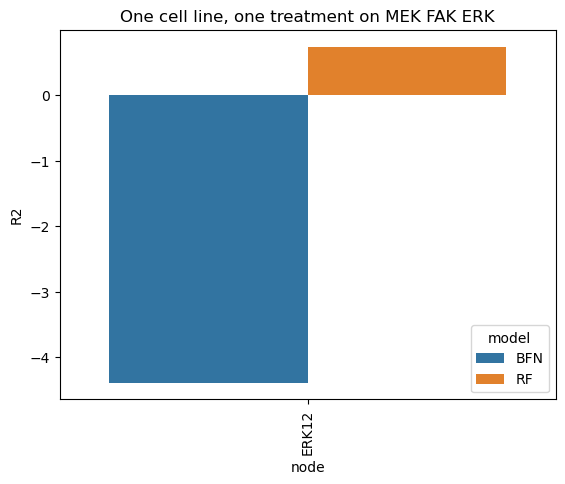

In [28]:
res = pd.DataFrame({"BFN": m_r2, "RF": bl_r2, "node": predicted_nodes})
res = res.melt(id_vars="node", value_vars=["BFN", "RF"], value_name="R2", var_name="model")
sns.barplot(data=res, x="node", y="R2", hue="model")
t = plt.xticks(rotation=90)
plt.title("One cell line, one treatment on MEK FAK ERK")